
# Getting Started: `netrad_limits.py`

This notebook walks through the main functions in your module:
- Quick net radiation range estimates (`estimate_net_radiation_range`, `add_buffer`)
- Computing potential shortwave radiation at top-of-atmosphere (`sw_in_pot_noaa`)
- Timestamp-alignment QA/QC analysis on an AmeriFlux-like file (`analyze_timestamp_alignment`, `flag_issues`, `plot_summary`)

> Files expected in the same environment:
> - Module: `/mnt/data/netrad_limits.py`
> - Data: `/mnt/data/AMF_US-CRT_BASE_HH_3-5.csv`


In [1]:

# Standard imports
import sys, importlib, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots display inline
%matplotlib inline

# Paths
MOD_PATH = Path("/mnt/data/netrad_limits.py")
DATA_PATH = Path("/mnt/data/AMF_US-CRT_BASE_HH_3-5.csv")

# Import the module directly from /mnt/data
sys.path.append("../../src/")
from micromet import netrad_limits as nl
importlib.reload(nl)

print("Loaded module:", nl.__name__, "from", nl.__file__)
print("Pandas:", pd.__version__, "| NumPy:", np.__version__)


Loaded module: micromet.qaqc.netrad_limits from c:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\docs\notebooks\../../src\micromet\qaqc\netrad_limits.py
Pandas: 2.3.2 | NumPy: 2.2.6



## 1) Quick net radiation range estimates

Use `estimate_net_radiation_range(doy, hour)` to get a plausible range of **net radiation** (W m⁻²) for a given day-of-year and hour, assuming clear sky and typical temperature bounds. 


DOY=172, hour=14: Net radiation ~ 419.4 to 750.9 W/m²
Buffered: (319.3584960001766, 850.8580013267506)


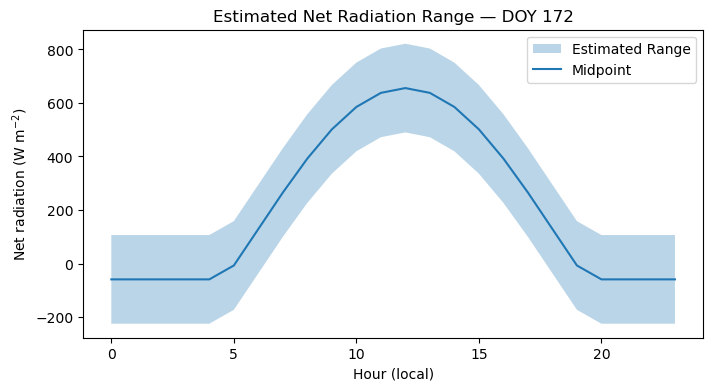

In [2]:

# Example: Summer solstice (~June 21 ≈ DOY 172), 14:00 local
doy = 172
hour = 14
rn_min, rn_max = nl.estimate_net_radiation_range(doy, hour)
print(f"DOY={doy}, hour={hour}: Net radiation ~ {rn_min:.1f} to {rn_max:.1f} W/m²")

# Add a ±100 W/m² buffer (floors at -200 W/m²)
print("Buffered:", nl.add_buffer((rn_min, rn_max), buffer=100))

# Diurnal range across 24 hours for the same DOY
hours = np.arange(24)
mins, maxs = zip(*[nl.estimate_net_radiation_range(doy, h) for h in hours])
mins = np.array(mins); maxs = np.array(maxs)

plt.figure(figsize=(8,4))
plt.fill_between(hours, mins, maxs, alpha=0.3, label="Estimated Range")
plt.plot(hours, (mins+maxs)/2.0, label="Midpoint")
plt.xlabel("Hour (local)"); plt.ylabel("Net radiation (W m$^{-2}$)")
plt.title("Estimated Net Radiation Range — DOY 172")
plt.legend()
plt.show()



## 2) Potential shortwave radiation at TOA (NOAA formulation)

`sw_in_pot_noaa` computes top-of-atmosphere potential shortwave irradiance (W m⁻²).  
**Input timestamps must be in *local standard time* (fixed UTC offset, no DST).**


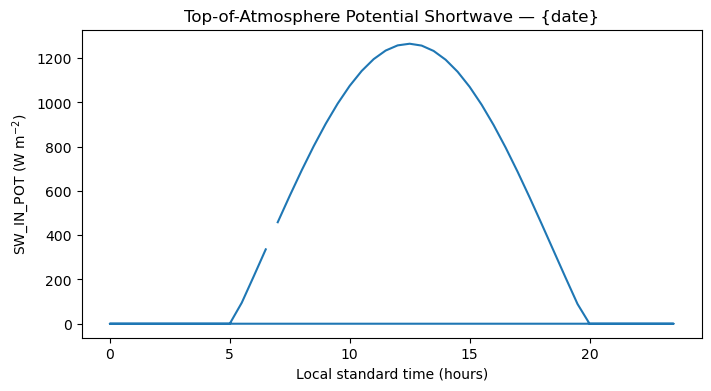

In [3]:

# Build a half-hourly local-standard-time index for a sample day
step_minutes = 30
date = "2024-06-21"
dt = pd.date_range(f"{date} 00:00", f"{date} 23:59", freq=f"{step_minutes}min", inclusive="both")

# Convert to fixed-offset tz (e.g., Mountain Standard Time = UTC-7)
dt_lst = nl._to_local_standard_time(dt, std_utc_offset_hours=-7, assume_naive_is_local=True)

# Compute potential irradiance for a Utah-like location
lat_deg = 39.5
lon_deg = -111.9
i0 = nl.sw_in_pot_noaa(dt_lst, lat_deg=lat_deg, lon_deg=lon_deg, std_utc_offset_hours=-7)

# Plot
plt.figure(figsize=(8,4))
plt.plot(i0.index.tz_convert(None).hour + i0.index.tz_convert(None).minute/60.0, i0.values)
plt.xlabel("Local standard time (hours)")
plt.ylabel("SW_IN_POT (W m$^{-2}$)")
plt.title("Top-of-Atmosphere Potential Shortwave — {date}")
plt.show()



## 3) Timestamp-alignment QA/QC on an AmeriFlux-like file

`analyze_timestamp_alignment` builds 15-day **maximum diurnal composites**, compares observed radiation to potential, and uses cross-correlation to estimate time lag.  
You can then summarize likely issues with `flag_issues` and visualize with `plot_summary`.


In [5]:

# Read the CSV (AmeriFlux BASE_HH-style)
df = pd.read_csv(DATA_PATH)

print("Rows x Cols:", df.shape)
print("First 5 columns:", list(df.columns[:5]))
display(df.head(3))

# Helper to find expected columns with fallbacks
def find_col(df, primary, contains=None):
    if primary in df.columns:
        return primary
    if contains is not None:
        # find the first column containing the substring (case-insensitive)
        for c in df.columns:
            if contains.lower() in c.lower():
                return c
    return None

start_col = find_col(df, "TIMESTAMP_START", contains="TIMESTAMP_START")
end_col   = find_col(df, "TIMESTAMP_END",   contains="TIMESTAMP_END")
sw_col    = find_col(df, "SW_IN",           contains="SW_IN")
ppfd_col  = find_col(df, "PPFD_IN",         contains="PPFD")

print("Using columns -> START:", start_col, "| END:", end_col, "| SW_IN:", sw_col, "| PPFD:", ppfd_col)

# Run analysis (assumes timestamps are UTC if naive; converted to fixed local standard time internally)
summary, composites = nl.analyze_timestamp_alignment(
    df,
    lat=39.5, lon=-111.9,
    std_utc_offset_hours=-7,   # Mountain Standard Time
    time_from="CENTER",
    start_col=start_col or "TIMESTAMP_START",
    end_col=end_col or "TIMESTAMP_END",
    sw_col=sw_col or "SW_IN",
    ppfd_col=ppfd_col or "PPFD_IN",
    assume_naive_is_local=False,
    max_lag_steps=6,
)

print("Summary shape:", summary.shape)
display(summary.head(10))

# Heuristic flags
flags = nl.flag_issues(summary)
print("\nHeuristic flags:")
for k, v in flags.items():
    print(f" - {k}: {v}")

# Plots (exceedance, lags, and worst-window overlay)
figs = nl.plot_summary(summary, composites)


FileNotFoundError: [Errno 2] No such file or directory: '\\mnt\\data\\AMF_US-CRT_BASE_HH_3-5.csv'


## 4) Save figures (optional)

Re-run the summary plotting and save PNG files with an `outfile_prefix`.


In [ ]:

out_prefix = "timestamp_alignment_demo"
_ = nl.plot_summary(summary, composites, outfile_prefix=out_prefix)

from pathlib import Path
list(Path(".").glob(out_prefix + "*.png"))



## Next steps
- Swap in real site latitude/longitude and the correct UTC offset for **local standard time** (no DST).
- Compare `lag_steps_sw`/`lag_steps_ppfd` across seasons; investigate large or systematic offsets.
- Inspect windows with large `% exceed` values for instrument issues (leveling/shading/calibration) or timestamp mismatches.
